In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.patches as patches
import pickle

In [2]:
mu = 0  # mean
stdev = 1  # standard deviation

# `x` span of +/- 4 standard deviations
x_start = mu - 4*stdev
x_end = mu + 4*stdev
step = 0.01

# Calculate `x` and `y`
x = np.arange(
    start=x_start,
    stop=x_end+step,
    step=step
)
y = norm.pdf(
    x=x,
    loc=mu,
    scale=stdev
)

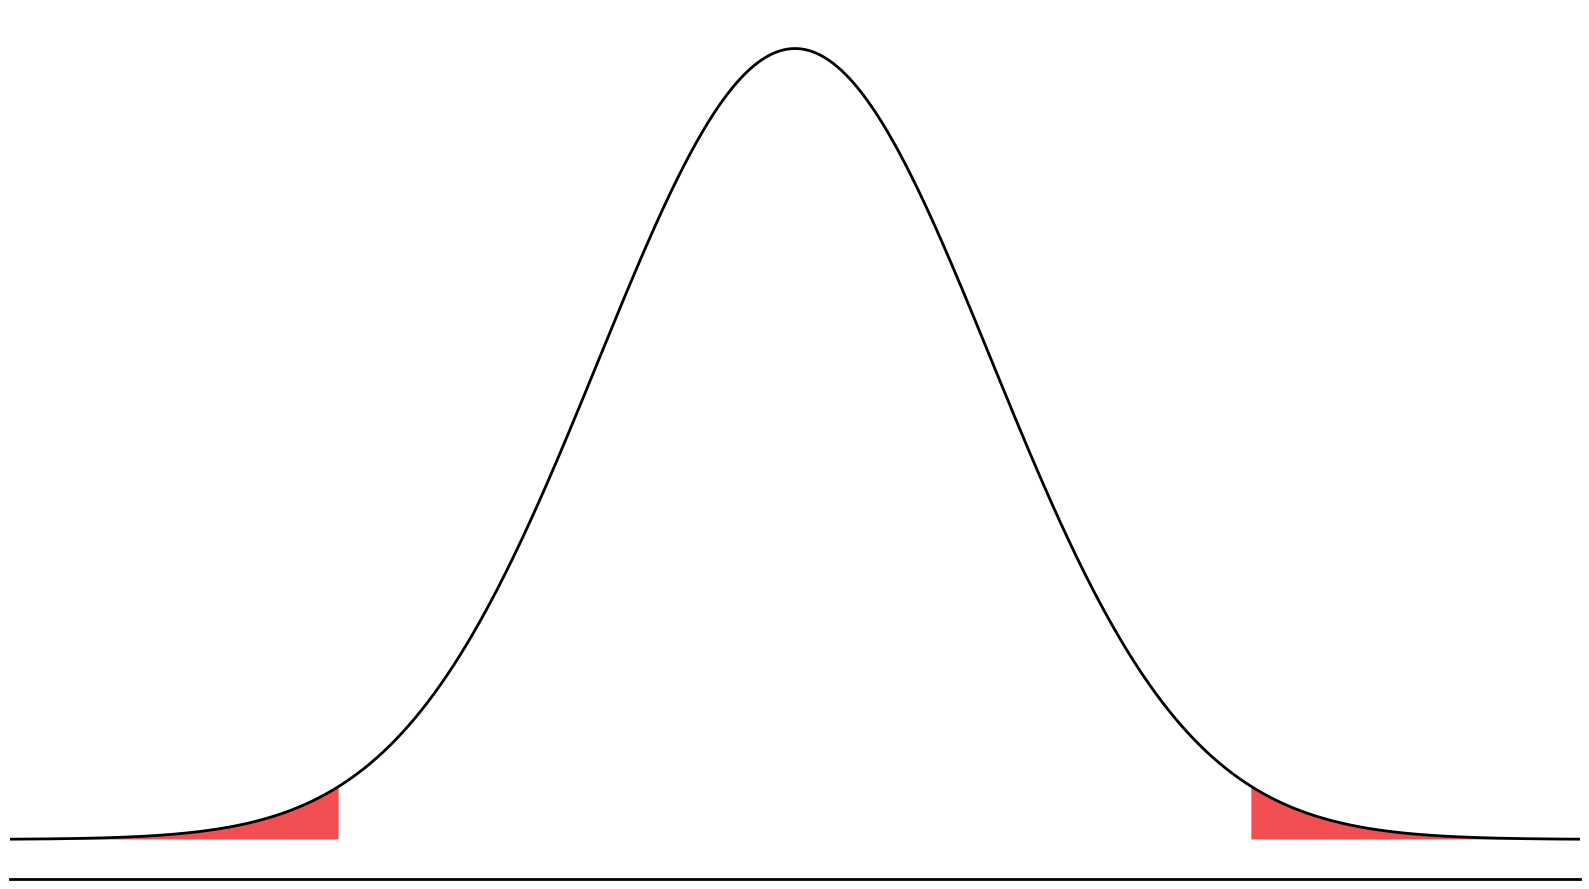

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# DATA
# ----
mu = 183  # mean male height in Netherlands according to WHO
stdev = 7.1  # standard deviation

x_start = mu - 4 * stdev
x_end = mu + 4 * stdev
step = 0.01

# CALCULATIONS
# ------------

# Calculate "x" and "y"
x = np.arange(
    start=x_start,
    stop=x_end + step,
    step=step
)
y = norm.pdf(
    x=x,
    loc=mu,
    scale=stdev
)

# Round "x"
x = np.around(x, 3)  # rounding solves the float number problem
# Add new observation
x_observed = 166.5
y_observed = y[x == x_observed]

# Calculate CDF and add alpha
y_cdf = norm.cdf(
    x=x,
    loc=mu,
    scale=stdev
)

# significance level alpha (two-sided)
alpha = 0.05
left_alpha = alpha / 2
right_alpha = 1 - (alpha / 2)

# PLOTTING
# --------
fig, ax = plt.subplots(
    figsize=(16, 9),
    facecolor="white"
)

# plot: normal distribution
ax.plot(
    x, y,
    label="probability density",
    color="black",
    linewidth=2,
)
# # plot: normal distribution fill
# ax.fill_between(
#     x, y,
#     color="white",
#     alpha=0.2,
# )

# plot: p-value
ax.fill_between(
    x, y,
    where=y < y_observed,
    label="p-value(E)",
    facecolor="#F14F51",
    edgecolor="none",
)

# SETTINGS
# Remove y-axis and top of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')

ax.yaxis.set_visible(False)  # Remove y-axis ticks and labels

# Customize x-axis
ax.spines['bottom'].set_linewidth(2)
ax.set_xticks([])
ax.set_xlim(x_start, x_end)

plt.tight_layout()
plt.savefig(
    fname="pvalue_final.png",
    format="png",
    dpi=125,
    transparent=True  # Make the background transparent
)
plt.show()

# Power Analysis

In [4]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


In [5]:
def simulate_data(sample_size, p_control_click, ate_click, p_control_sign_up, ate_sign_up):
    np.random.seed(1234)
    
    # Determine sample sizes per group
    number_of_treatment = sample_size // 2
    number_of_control = sample_size - number_of_treatment
    
    # Create condition array
    condition = np.array(['control'] * number_of_control + ['treatment'] * number_of_treatment)
    d = pd.DataFrame({'condition': condition})
    
    # Assign click probabilities
    # For control: runif(.N) ~ np.random.rand(len(control))
    # For treatment: runif(.N) + ate_click
    d.loc[d['condition'] == 'control', 'click_prob'] = np.random.rand(number_of_control)
    d.loc[d['condition'] == 'treatment', 'click_prob'] = np.random.rand(number_of_treatment) + ate_click
    
    # Y_click: ifelse(click_prob >= (1 - p_control_click), 1, 0)
    d['Y_click'] = (d['click_prob'] >= (1 - p_control_click)).astype(int)
    
    # Assign sign-up probabilities
    # For control: Y_click * runif(.N)
    # For treatment: Y_click * (runif(.N) + ate_sign_up)
    d.loc[d['condition'] == 'control', 'sign_up_prob'] = d.loc[d['condition'] == 'control', 'Y_click'] * np.random.rand(number_of_control)
    d.loc[d['condition'] == 'treatment', 'sign_up_prob'] = d.loc[d['condition'] == 'treatment', 'Y_click'] * (np.random.rand(number_of_treatment) + ate_sign_up)
    
    # Y_sign_up: ifelse(sign_up_prob >= (1 - p_control_sign_up), 1, 0)
    d['Y_sign_up'] = (d['sign_up_prob'] >= (1 - p_control_sign_up)).astype(int)
    
    return d

In [6]:
def regression_p_values(df, sample_size_per_group, outcome_var, iterations):
    p_values = np.zeros(iterations)
    last_mod_HC = None
    
    for i in range(iterations):
        # Sample from control and treatment with replacement
        control_df = df[df['condition'] == 'control'].sample(n=sample_size_per_group, replace=True, random_state=None)
        treatment_df = df[df['condition'] == 'treatment'].sample(n=sample_size_per_group, replace=True, random_state=None)
        
        table = pd.concat([control_df, treatment_df], ignore_index=True)
        
        # Fit model with robust standard errors
        # Using categorical coding: C(condition) will create a dummy for treatment vs control
        formula = f"{outcome_var} ~ C(condition)"
        mod = smf.ols(formula, data=table).fit(cov_type='HC0')
        
        # Extract p-value for treatment effect:
        # The coefficient for treatment is typically labeled 'C(condition)[T.treatment]'
        p_values[i] = mod.pvalues.get('C(condition)[T.treatment]', np.nan)
        
        if i == iterations - 1:
            last_mod_HC = mod
    
    # Proportion of p-values < 0.05
    reject_rate = np.mean(p_values < 0.05)
    
    return {
        'p_values': p_values,
        'reject_rate': reject_rate,
        'mod_HC': last_mod_HC
    }


In [7]:
def calculate_power_vs_sample_size(d, outcome_var, percentages_to_sample, iterations):
    n_original = len(d)
    power_by_sample_size = np.zeros(len(percentages_to_sample))
    
    for i, perc in enumerate(percentages_to_sample):
        n_to_sample_per_group = int(round(n_original * perc / 2))
        # Run the regression-based p-value calculation
        reg_result = regression_p_values(d, n_to_sample_per_group, outcome_var, iterations)
        power_by_sample_size[i] = reg_result['reject_rate']
        
    power_df = pd.DataFrame({'percentage': percentages_to_sample, 'power': power_by_sample_size})
    return power_df

In [8]:
def simulate_power(d, sample_size, percentages_to_sample, ri_iterations):
    np.random.seed(1234)
    
    # Summary table
    # summary_table = d.groupby('condition').agg({'Y_click':'mean', 'Y_sign_up':'mean'}).reset_index()
    
    # Calculate power for Y_click
    power_df_ctr = calculate_power_vs_sample_size(d, "Y_click", percentages_to_sample, iterations=ri_iterations)
    
    # Calculate power for Y_sign_up
    power_df_signup = calculate_power_vs_sample_size(d, "Y_sign_up", percentages_to_sample, iterations=ri_iterations)
    
    return {
        # 'summary_table': summary_table,
        'power_df_ctr': power_df_ctr,
        'power_df_signup': power_df_signup
    }


In [9]:
# Population of 100,000 we sample from with replacement
sample_size = 100000
iterations = 1000
percentages_to_sample = np.arange(0.1, 0.501, 0.02)

# Scenario 1
p_control_click = 0.01
ate_click = 0.001
p_control_sign_up = 0.05
ate_sign_up = 0.01

# d = simulate_data(sample_size, p_control_click, ate_click, p_control_sign_up, ate_sign_up)
# result_scenario_1 = simulate_power(d, sample_size=sample_size, percentages_to_sample=percentages_to_sample, ri_iterations=iterations)

In [10]:
# # Save the result to a file
# with open("result_scenario_1.pkl", "wb") as f:
#     pickle.dump(result_scenario_1, f)

# Later, to load the results
with open("result_scenario_1.pkl", "rb") as f:
    result_scenario_1 = pickle.load(f)

In [11]:

# # Scenario 2
# p_control_click = 0.01
# ate_click = 0.005
# p_control_sign_up = 0.05
# ate_sign_up = 0.01
# d = simulate_data(sample_size, p_control_click, ate_click, p_control_sign_up, ate_sign_up)
# result_scenario_2 = simulate_power(d, sample_size=sample_size, percentages_to_sample=percentages_to_sample, ri_iterations=iterations)

# # Scenario 3
# p_control_click = 0.01
# ate_click = 0.01
# p_control_sign_up = 0.05
# ate_sign_up = 0.01
# d = simulate_data(sample_size, p_control_click, ate_click, p_control_sign_up, ate_sign_up)
# result_scenario_3 = simulate_power(d, sample_size=sample_size, percentages_to_sample=percentages_to_sample, ri_iterations=iterations)



In [12]:
# # Save the result to a file
# with open("result_scenario_2.pkl", "wb") as f:
#     pickle.dump(result_scenario_2, f)

# # Save the result to a file
# with open("result_scenario_3.pkl", "wb") as f:
#     pickle.dump(result_scenario_3, f)

In [13]:
with open("result_scenario_2.pkl", "rb") as f:
    result_scenario_2 = pickle.load(f)

with open("result_scenario_3.pkl", "rb") as f:
    result_scenario_3 = pickle.load(f)

## Plot scenarios

In [14]:
result_scenario_3

{'power_df_ctr':     percentage  power
 0         0.10  0.987
 1         0.12  0.998
 2         0.14  0.998
 3         0.16  1.000
 4         0.18  1.000
 5         0.20  1.000
 6         0.22  1.000
 7         0.24  1.000
 8         0.26  1.000
 9         0.28  1.000
 10        0.30  1.000
 11        0.32  1.000
 12        0.34  1.000
 13        0.36  1.000
 14        0.38  1.000
 15        0.40  1.000
 16        0.42  1.000
 17        0.44  1.000
 18        0.46  1.000
 19        0.48  1.000
 20        0.50  1.000,
 'power_df_signup':     percentage  power
 0         0.10  0.158
 1         0.12  0.217
 2         0.14  0.242
 3         0.16  0.293
 4         0.18  0.316
 5         0.20  0.375
 6         0.22  0.377
 7         0.24  0.405
 8         0.26  0.423
 9         0.28  0.497
 10        0.30  0.502
 11        0.32  0.541
 12        0.34  0.574
 13        0.36  0.592
 14        0.38  0.609
 15        0.40  0.604
 16        0.42  0.622
 17        0.44  0.703
 18        0.46  0.67

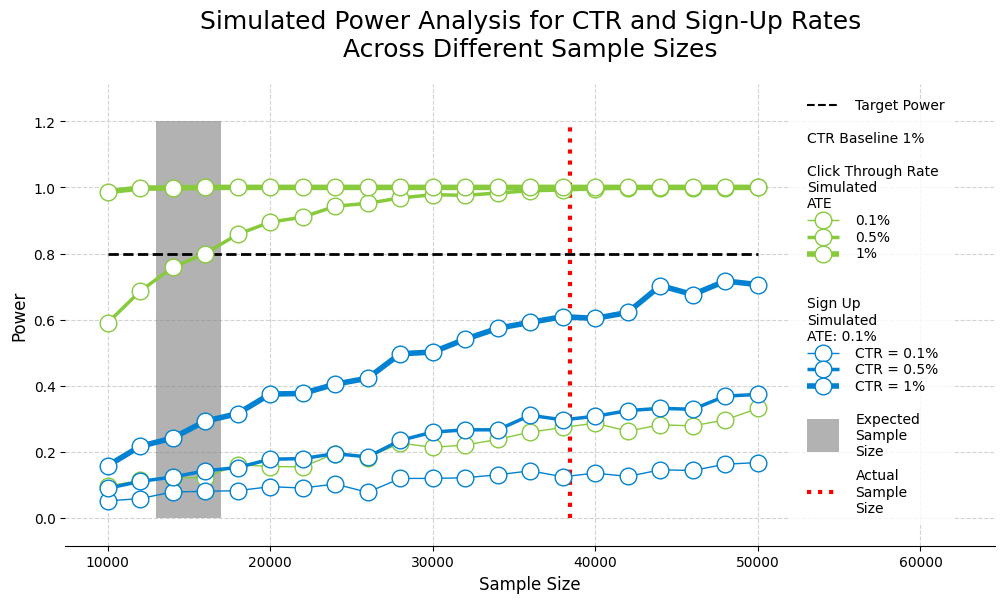

In [28]:
# Extract the dataframes
df_ctr_1 = result_scenario_1['power_df_ctr']
df_signup_1 = result_scenario_1['power_df_signup']

df_ctr_2 = result_scenario_2['power_df_ctr']
df_signup_2 = result_scenario_2['power_df_signup']

df_ctr_3 = result_scenario_3['power_df_ctr']
df_signup_3 = result_scenario_3['power_df_signup']

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.grid(axis='y', color='lightgray', linestyle='--')
ax.grid(axis='x', color='lightgray', linestyle='--')

# Add rectangle
rect1 = patches.Rectangle(
    (13000, 0),
    width=4000,
    height=1.2,
    facecolor = 'grey',
    linewidth=0,
    edgecolor=None,
    alpha=0.6,
    zorder=2
    )
ax.add_patch(rect1)

plt.vlines(38427, ymin=0, ymax=1.2,linewidth=3,
          linestyle='dotted',
          color = 'red' )

ax.hlines(0.8, xmin=10000, xmax=50000,
         linewidth=2,
          linestyle='--',
          color = 'black'
         )

# ax.hlines(0.01, xmin=10000, xmax=50000,
#          linewidth=1.5,
#           linestyle='dotted',
#           color = 'black'
#          )

# Plot CTR power vs percentage (no labels)
ax.plot(df_ctr_1['percentage'] * sample_size, df_ctr_1['power'], 
        marker='.', 
        markersize=24, 
        markerfacecolor='white',
        linewidth=1,
        color = '#87CA3C')
ax.plot(df_ctr_2['percentage'] * sample_size, df_ctr_2['power'],
        marker='.', 
        markersize=24, 
        markerfacecolor='white',
        linewidth=2.5,
        color = '#87CA3C')
ax.plot(df_ctr_3['percentage'] * sample_size, df_ctr_3['power'], 
        marker='.', 
        markersize=24, 
        markerfacecolor='white',
        linewidth=4,
        color = '#87CA3C')

# Plot Sign-Up power vs percentage (no labels)
ax.plot(df_signup_1['percentage'] * sample_size, df_signup_1['power'], 
        marker='.', 
        markersize=24, 
        markerfacecolor='white',
        linewidth=1,
        color = '#0081D1')
ax.plot(df_signup_2['percentage'] * sample_size, df_signup_2['power'], 
        marker='.', 
        markersize=24, 
        markerfacecolor='white',
        linewidth=2.5,
        color = '#0081D1')
ax.plot(df_signup_3['percentage'] * sample_size, df_signup_3['power'], 
        marker='.', 
        markersize=24, 
        markerfacecolor='white',
        linewidth=4,
        color = '#0081D1')


# Set labels
ax.set_xlabel('Sample Size', size=12)
ax.set_ylabel('Power', size=12)
ax.set_title('Simulated Power Analysis for CTR and Sign-Up Rates\nAcross Different Sample Sizes',
             size=18,
             pad=20)

# Legend

rect2 = patches.Rectangle(
    (52000, -0.02),
    width=10000, height=1.25, facecolor = 'white', linewidth=0,
    alpha = 0.8, edgecolor=None, zorder=2)
ax.add_patch(rect2)

ax.text(53000, 1, 'Click Through Rate\nSimulated\nATE', size=10, ha='left', va='center')

ax.hlines(0.9, xmin=53000, xmax=55000, linewidth=1, color = '#87CA3C')
ax.plot(54000, 0.9,  marker='.', color = '#87CA3C', markersize=24, markerfacecolor='white')

ax.hlines(0.85, xmin=53000, xmax=55000,linewidth=2.5,color = '#87CA3C')
ax.plot(54000, 0.85,  marker='.', color = '#87CA3C', markersize=24, markerfacecolor='white')

ax.hlines(0.8, xmin=53000, xmax=55000,linewidth=4,color = '#87CA3C')
ax.plot(54000, 0.8,  marker='.', color = '#87CA3C', markersize=24, markerfacecolor='white')

ax.text(56000, 0.9, '0.1%', size=10, ha='left', va='center')
ax.text(56000, 0.85,'0.5%', size=10, ha='left', va='center')
ax.text(56000, 0.8,'1%', size=10, ha='left', va='center')


ax.text(53000, 0.6,'Sign Up\nSimulated\nATE: 0.1%', size=10, ha='left', va='center')

ax.hlines(0.5, xmin=53000, xmax=55000,linewidth=1,color = '#0081D1')
ax.plot(54000, 0.5,  marker='.', color = '#0081D1', markersize=24, markerfacecolor='white')

ax.hlines(0.45, xmin=53000, xmax=55000,linewidth=2.5,color = '#0081D1')
ax.plot(54000, 0.45,  marker='.', color = '#0081D1', markersize=24, markerfacecolor='white')

ax.hlines(0.4, xmin=53000, xmax=55000,linewidth=4,color = '#0081D1')
ax.plot(54000, 0.4,  marker='.', color = '#0081D1', markersize=24, markerfacecolor='white')

ax.text(56000, 0.5,'CTR = 0.1%', size=10, ha='left', va='center')
ax.text(56000, 0.45,'CTR = 0.5%', size=10, ha='left', va='center')
ax.text(56000, 0.4,'CTR = 1%', size=10, ha='left', va='center')

# rect2 = patches.Rectangle(
#     (25000, 0.755),
#     width=10000, height=0.1, facecolor = 'white', linewidth=0,
#     alpha = 0.9, edgecolor=None, zorder=3)
# ax.add_patch(rect2)
# ax.text(30000, 0.8,'Target  Power', size=14, ha='center', va='center')

# Add rectangle
rect1 = patches.Rectangle(
    (53000, 0.2),
    width=2000,
    height=0.1,
    facecolor = 'grey',
    linewidth=0,
    edgecolor=None,
    alpha=0.6,
    zorder=2
    )
ax.add_patch(rect1)
ax.text(56000, 0.25,'Expected\nSample\nSize', size=10, ha='left', va='center')

ax.hlines(1.25, xmin=53000, xmax=55000,linewidth=1.5, linestyle='--', color = 'black')
ax.text(56000, 1.25,'Target Power', size=10, ha='left', va='center')

# ax.plot( 55000, 1.15,markersize=10, marker='.', color = 'black')
ax.text(53000, 1.15,'CTR Baseline 1%', size=10, ha='left', va='center')

ax.hlines(0.08, xmin=53000, xmax=55000,linewidth=3, linestyle='dotted', color = 'red')
ax.text(56000, 0.08,'Actual\nSample\nSize', size=10, ha='left', va='center')


# Display the plot
plt.savefig('power_analysis.png', dpi=125, transparent=True)
plt.show()

In [16]:
19107+19320

38427